In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import hstack
import os
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from datetime import datetime

In [2]:
TRAIN_FILE = '../../dataset/COL774_drug_review/DrugsComTrain.csv'
TEST_FILE = '../../dataset/COL774_drug_review/DrugsComTest.csv'
VAL_FILE = '../../dataset/COL774_drug_review/DrugsComVal.csv'

train_dataset = pd.read_csv(TRAIN_FILE)
# train_dataset.dropna(axis=0, inplace=True)

test_dataset = pd.read_csv(TEST_FILE)
# test_dataset.dropna(axis=0, inplace=True)

val_dataset = pd.read_csv(VAL_FILE)
# val_dataset.dropna(axis=0, inplace=True)


In [3]:
def printAccuracy(model, X, y, X_test, y_test, X_val, y_val):
    print('Training Accuracy: ', model.score(X, y))
    print('Testing Accuracy: ', model.score(X_test, y_test))
    print('Validation Accuracy: ', model.score(X_val, y_val))

In [4]:
import re

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^A-Za-z ]+', '', text)
    text = re.sub(r' +', ' ', text)
    return text

def get_features(dataset, cond_vectorizer, review_vectorizer, method='transform'):
    dataset['review'] = dataset['review'].fillna('')
    dataset['condition'] = dataset['condition'].fillna('')
    dataset.dropna(axis=0, inplace=True)

    stop_words = set(stopwords.words('english'))
    
    
    dataset['review'] = dataset['review'].apply(preprocess)
    dataset['review'] = dataset['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    
    if method == 'fit':
        X1 = cond_vectorizer.fit_transform(dataset['condition'])
        X2 = review_vectorizer.fit_transform(dataset['review'])
        X = hstack([X1, X2])
    else:
        X1 = cond_vectorizer.transform(dataset['condition'])
        X2 = review_vectorizer.transform(dataset['review'])
        X = hstack([X1, X2])
    
    X_d = [datetime.strptime(date, '%B %d, %Y').date() for date in dataset['date']]
    X_d = [[d.day, d.month, d.year] for d in X_d]
    
    X = hstack([X, X_d, dataset[['usefulCount']].values])
    y = dataset['rating']

    return X, y


In [5]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112272 entries, 0 to 112907
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   condition    112272 non-null  object
 1   review       112272 non-null  object
 2   rating       112272 non-null  int64 
 3   date         112272 non-null  object
 4   usefulCount  112272 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 5.1+ MB


In [5]:
cond_vectorizer = TfidfVectorizer(input='content')
review_vectorizer = TfidfVectorizer(input='content')

In [6]:
X_train, y_train = get_features(train_dataset, cond_vectorizer, review_vectorizer, method='fit')

In [7]:
X_test, y_test = get_features(test_dataset, cond_vectorizer, review_vectorizer)
X_val, y_val = get_features(val_dataset, cond_vectorizer, review_vectorizer)

In [8]:
print(X_train.shape)
print(review_vectorizer.get_feature_names_out()[20000:20050])

(112908, 69371)
['exforge' 'exgirlfriend' 'exhale' 'exhaused' 'exhaust' 'exhausted'
 'exhaustedam' 'exhaustedfor' 'exhaustedit' 'exhaustedmy'
 'exhaustednauseous' 'exhaustedwired' 'exhaustedyet' 'exhausting'
 'exhaustingi' 'exhaustion' 'exhaustionadditional' 'exhaustionand'
 'exhaustionenter' 'exhaustive' 'exhausts' 'exheroin' 'exhibit'
 'exhibited' 'exhibiting' 'exhibits' 'exhilarated' 'exhilarating'
 'exhuasted' 'exhuasting' 'exhusband' 'exhusted' 'exicted' 'exinsomniac'
 'exist' 'existant' 'existed' 'existedgrief' 'existence' 'existencebeen'
 'existencebut' 'existent' 'existenti' 'existential' 'existentnot'
 'existentthese' 'existentthis' 'existentvery' 'existentyay' 'existing']


In [9]:
from contextlib import redirect_stdout
def write_accuracies(model, filename, X_train, y_train, X_test, y_test, X_val, y_val):
    with open(filename, 'a+') as f:
        with redirect_stdout(f):
            print('Training Accuracy: ', model.score(X_train, y_train))
            print('Testing Accuracy: ', model.score(X_test, y_test))
            print('Validation Accuracy: ', model.score(X_val, y_val))

In [57]:
def a_decision_tree(X_train, y_train, X_test, y_test, X_val, y_val, filename, subpart='a'):
    dt_model = DecisionTreeClassifier(random_state=0)
    dt_model.fit(X_train, y_train)
    write_accuracies(dt_model, filename, X_train, y_train, X_test, y_test, X_val, y_val)

In [11]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

In [17]:
printAccuracy(model, X_train, y_train, X_test, y_test, X_val, y_val)

Training Accuracy:  1.0
Testing Accuracy:  0.5676347926913654
Validation Accuracy:  0.570336200806217


In [58]:
a_decision_tree(X_train, y_train, X_test, y_test, X_val, y_val, os.path.join('../../outputs/Q1/', '2_a.txt'))

In [12]:
ccp_path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = ccp_path.ccp_alphas, ccp_path.impurities

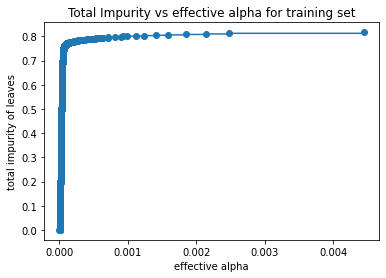

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
fig.savefig('../../outputs/Q1/2_c_alpha_vs_imp.png', dpi=300)

In [14]:
print(ccp_alphas.shape)

(23400,)


In [12]:
test_clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alphas[15861])
test_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=2.630973131186898e-05, random_state=0)

In [15]:
ccp_alphas = ccp_alphas[::4000]

In [16]:
ccp_models = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    ccp_models.append(clf)

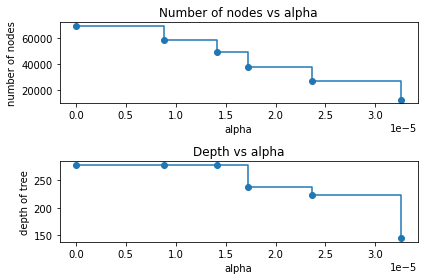

In [17]:
# ccp_models = ccp_models[:-1]
# ccp_alphas = ccp_alphas[:-1]

node_counts = [model.tree_.node_count for model in ccp_models]
depth = [model.tree_.max_depth for model in ccp_models]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
fig.savefig('../../outputs/Q1/2_c_alpha_vs_nodes.png', dpi=300)

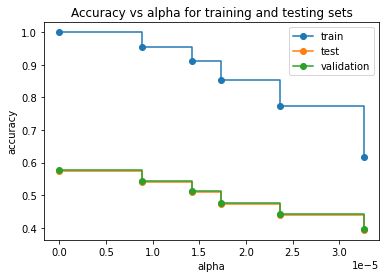

In [19]:
train_scores = [model.score(X_train, y_train) for model in ccp_models]
test_scores = [model.score(X_test, y_test) for model in ccp_models]
val_scores = [model.score(X_val, y_val) for model in ccp_models]

fig, ax = plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy vs alpha for training and testing sets')
ax.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle='steps-post')
ax.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle='steps-post')
ax.plot(ccp_alphas, val_scores, marker='o', label='validation', drawstyle='steps-post')
ax.legend()
fig.savefig('../../outputs/Q1/2_c_accuracy_vs_alpha.png', dpi=300)
# plt.show()

In [20]:
ccp_model = ccp_models[np.argmax(val_scores)]
printAccuracy(ccp_model, X_train, y_train, X_test, y_test, X_val, y_val)
write_accuracies(ccp_model, '../../outputs/Q1/2_c.txt', X_train, y_train, X_test, y_test, X_val, y_val)

Training Accuracy:  1.0
Testing Accuracy:  0.5746196481047502
Validation Accuracy:  0.5772386286139412


In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=50, max_features=0.4, min_samples_split=2, n_jobs=-1)
rf_model.fit(X_train, y_train)

In [26]:
printAccuracy(rf_model, X_train, y_train, X_test, y_test, X_val, y_val)

Training Accuracy:  0.9999554652985606
Testing Accuracy:  0.6407772437395972
Validation Accuracy:  0.6427710593026639


In [27]:
rf_model = RandomForestClassifier(n_estimators=100, max_features=0.5, min_samples_split=2, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_features=0.5, n_jobs=-1)

In [28]:
printAccuracy(rf_model, X_train, y_train, X_test, y_test, X_val, y_val)

Training Accuracy:  1.0
Testing Accuracy:  0.641226085167661
Validation Accuracy:  0.6424593774674812


In [12]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [ ]:
xgb_model = xgb.XGBClassifier(n_estimators=100, subsample=0.6, max_depth=50, n_jobs=-1)
xgb_model.fit(X_train, y_train)

printAccuracy(xgb_model, X_train, y_train, X_test, y_test, X_val, y_val)

In [32]:

printAccuracy(xgb_model, X_train, y_train, X_test, y_test, X_val, y_val)

Training Accuracy:  1.0
Testing Accuracy:  0.6486132670045445
Validation Accuracy:  0.6498981839338404


In [13]:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(max_depth=250, n_estimators=200, subsample=0.4, n_jobs=-1)
lgbm_model.fit(X_train, y_train)

printAccuracy(lgbm_model, X_train, y_train, X_test, y_test, X_val, y_val)

c:\Users\INTEL\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


Training Accuracy:  0.7420550092632179


c:\Users\INTEL\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


Testing Accuracy:  0.5231059826822015


c:\Users\INTEL\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


Validation Accuracy:  0.5228358891243818


In [23]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from scipy.sparse import vstack


In [ ]:

params = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450],
    'subsample': [0.4, 0.5, 0.6, 0.7, 0.8],
    'max_depth': [40, 50, 60, 70],
}

cv = np.concatenate((-1*np.ones((X_train.shape[0], 1)), np.zeros((X_val.shape[0], 1))), axis=0)
cv = PredefinedSplit(cv)
lgbm_model = GridSearchCV(estimator=LGBMClassifier(random_state=0, n_jobs=-1), param_grid=params, cv=cv, scoring='accuracy', n_jobs=-1, refit=True, error_score='raise')

X_cv = vstack([X_train, X_val])
y_cv = np.concatenate([y_train, y_val], axis=0)
lgbm_model.fit(X_cv, y_cv)

print(lgbm_model.best_params_)
printAccuracy(lgbm_model, X_train, y_train, X_test, y_test, X_val, y_val)

In [24]:
def d_random_forest(X_train, y_train, X_test, y_test, X_val, y_val, filename, subpart='d'):
    params = {
        'n_estimators': [50, 450],
        'max_features': [0.4, 0.8],
        'min_samples_split': [2, 6],
    }

    cv = np.concatenate((-1*np.ones((X_train.shape[0], 1)), np.zeros((X_val.shape[0], 1))), axis=0)
    cv = PredefinedSplit(cv)
    rf_model = GridSearchCV(estimator=RandomForestClassifier(oob_score=True, random_state=0), param_grid=params, cv=cv, scoring='accuracy', n_jobs=-1, refit=True, error_score='raise')
    
    X_cv = vstack([X_train, X_val])
    y_cv = np.concatenate([y_train, y_val], axis=0)
    rf_model.fit(X_cv, y_cv)

    write_accuracies(rf_model, filename, X_train, y_train, X_test, y_test, X_val, y_val)
    with open(filename, 'a') as f:
        with redirect_stdout(f):
            print('OOB Accuracy: ', rf_model.best_estimator_.oob_score_)
            print(rf_model.best_params_)

In [27]:
with open(os.path.join('', '2_d.txt'), 'w') as f:
    f.write('')
d_random_forest(X_train, y_train, X_test, y_test, X_val, y_val, os.path.join('', '2_d.txt'))

In [21]:
def f_lgbm(X_train, y_train, X_test, y_test, X_val, y_val, filename, subpart='f'):
    params = {
        'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450],
        'subsample': [0.4, 0.5, 0.6, 0.7, 0.8],
        'max_depth': [40, 50, 60, 70],
    }

    cv = np.concatenate((-1*np.ones((X_train.shape[0], 1)), np.zeros((X_val.shape[0], 1))), axis=0)
    cv = PredefinedSplit(cv)
    lgbm_model = GridSearchCV(estimator=LGBMClassifier(random_state=0, n_jobs=-1), param_grid=params, cv=cv, scoring='accuracy', n_jobs=-1, refit=True, error_score='raise')
    
    X_cv = vstack([X_train, X_val])
    y_cv = np.concatenate([y_train, y_val], axis=0)
    lgbm_model.fit(X_cv, y_cv)

    write_accuracies(lgbm_model, filename, X_train, y_train, X_test, y_test, X_val, y_val)
    with open(filename, 'a') as f:
        with redirect_stdout(f):
            print(lgbm_model.best_params_)

In [22]:

with open(os.path.join('', '2_f.txt'), 'w') as f:
    f.write('')
f_lgbm(X_train, y_train, X_test, y_test, X_val, y_val, os.path.join('', '2_f.txt'))

NameError: name 'PredefinedSplit' is not defined